In [1]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tempfile
tmpdir=tempfile.gettempdir()
import matplotlib.gridspec as gridspec
#from profile_surface import surface_smoothing

In [2]:
def surface_smoothing(values, surf_filename, fwhm=2):
    """smooth surface values using depth_potential. Will loop over multiple values if necessary
    smooths across surf_filename with fwhm set"""
    #check dimensions
    shrink=False
    flipped=False
    if np.ndim(values)==1:
        values=np.array([values])
        shrink=True
    elif values.shape[0]>values.shape[1]:
        values=values.T
        flipped=True
    new_values=np.zeros_like(values)
    for k,overlay in enumerate(values):
        np.savetxt('/tmp/tmp.txt', overlay, fmt='%i')
        print('smoothing surface '+str(k))
        subprocess.call('depth_potential -smooth '+ str(fwhm)+' /tmp/tmp.txt '+ surf_filename + ' /tmp/smtmp.txt',shell=True)
        new_overlay = np.round(np.loadtxt('/tmp/smtmp.txt')).astype(int)
        new_values[k] = new_overlay
    if shrink:
        return new_values[0]
    else:
        if flipped==True:
            return new_values.T
        return new_values

In [3]:

def plot_surface(overlay,surface_file, mask=False, min_val=None, max_val=None):
    """ plot surface overlays using ray_trace"""
    if min_val or max_val:
        overlay=np.clip(overlay, min_val,max_val)
    if mask is not False:
        overlay[mask==1]=min_val-0.01
    np.savetxt(os.path.join(tmpdir, 'tmp.txt'), overlay)
    subprocess.call('colour_object ' + surface_file + ' ' + os.path.join(tmpdir,'tmp.txt ') + os.path.join(tmpdir, 'tmp.obj ' )
                   + 'spectral ' + str(min(overlay)) + ' '+ str(max(overlay)), shell=True )
    #save two views
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, 'tmp.obj ' ) +'-bg white -sup 3 -crop -left -size 1000 1000 -output ' +  os.path.join(tmpdir, 'tmp_l.rgb' ),shell=True)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, 'tmp.obj ' ) +'-bg white -sup 3 -crop -right -size 1000 1000 -output ' +  os.path.join(tmpdir, 'tmp_r.rgb' ),shell=True)
    subprocess.call('create_bar_graph -colour spectral -width 25 -bg white ' + os.path.join(tmpdir, 'tmp_bar.png'),shell=True)
    imagel=plt.imread( os.path.join(tmpdir, 'tmp_l.rgb' ))
    imager=plt.imread( os.path.join(tmpdir, 'tmp_r.rgb' ))
    bar = plt.imread( os.path.join(tmpdir, 'tmp_bar.png'))
    return imagel,imager,bar

In [6]:
overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/lthickness_left_total.txt')
surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_left_327680.obj'
mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_left.txt')

In [66]:
mu=np.mean(overlay[mask!=1])
sigma=np.std(overlay[mask!=1])
min_val=mu-3*sigma
max_val=mu+3*sigma


In [67]:

l,r, bar = plot_surface(overlay, surface_file,mask=mask, min_val=min_val, max_val=max_val)

<IPython.core.display.Javascript object>


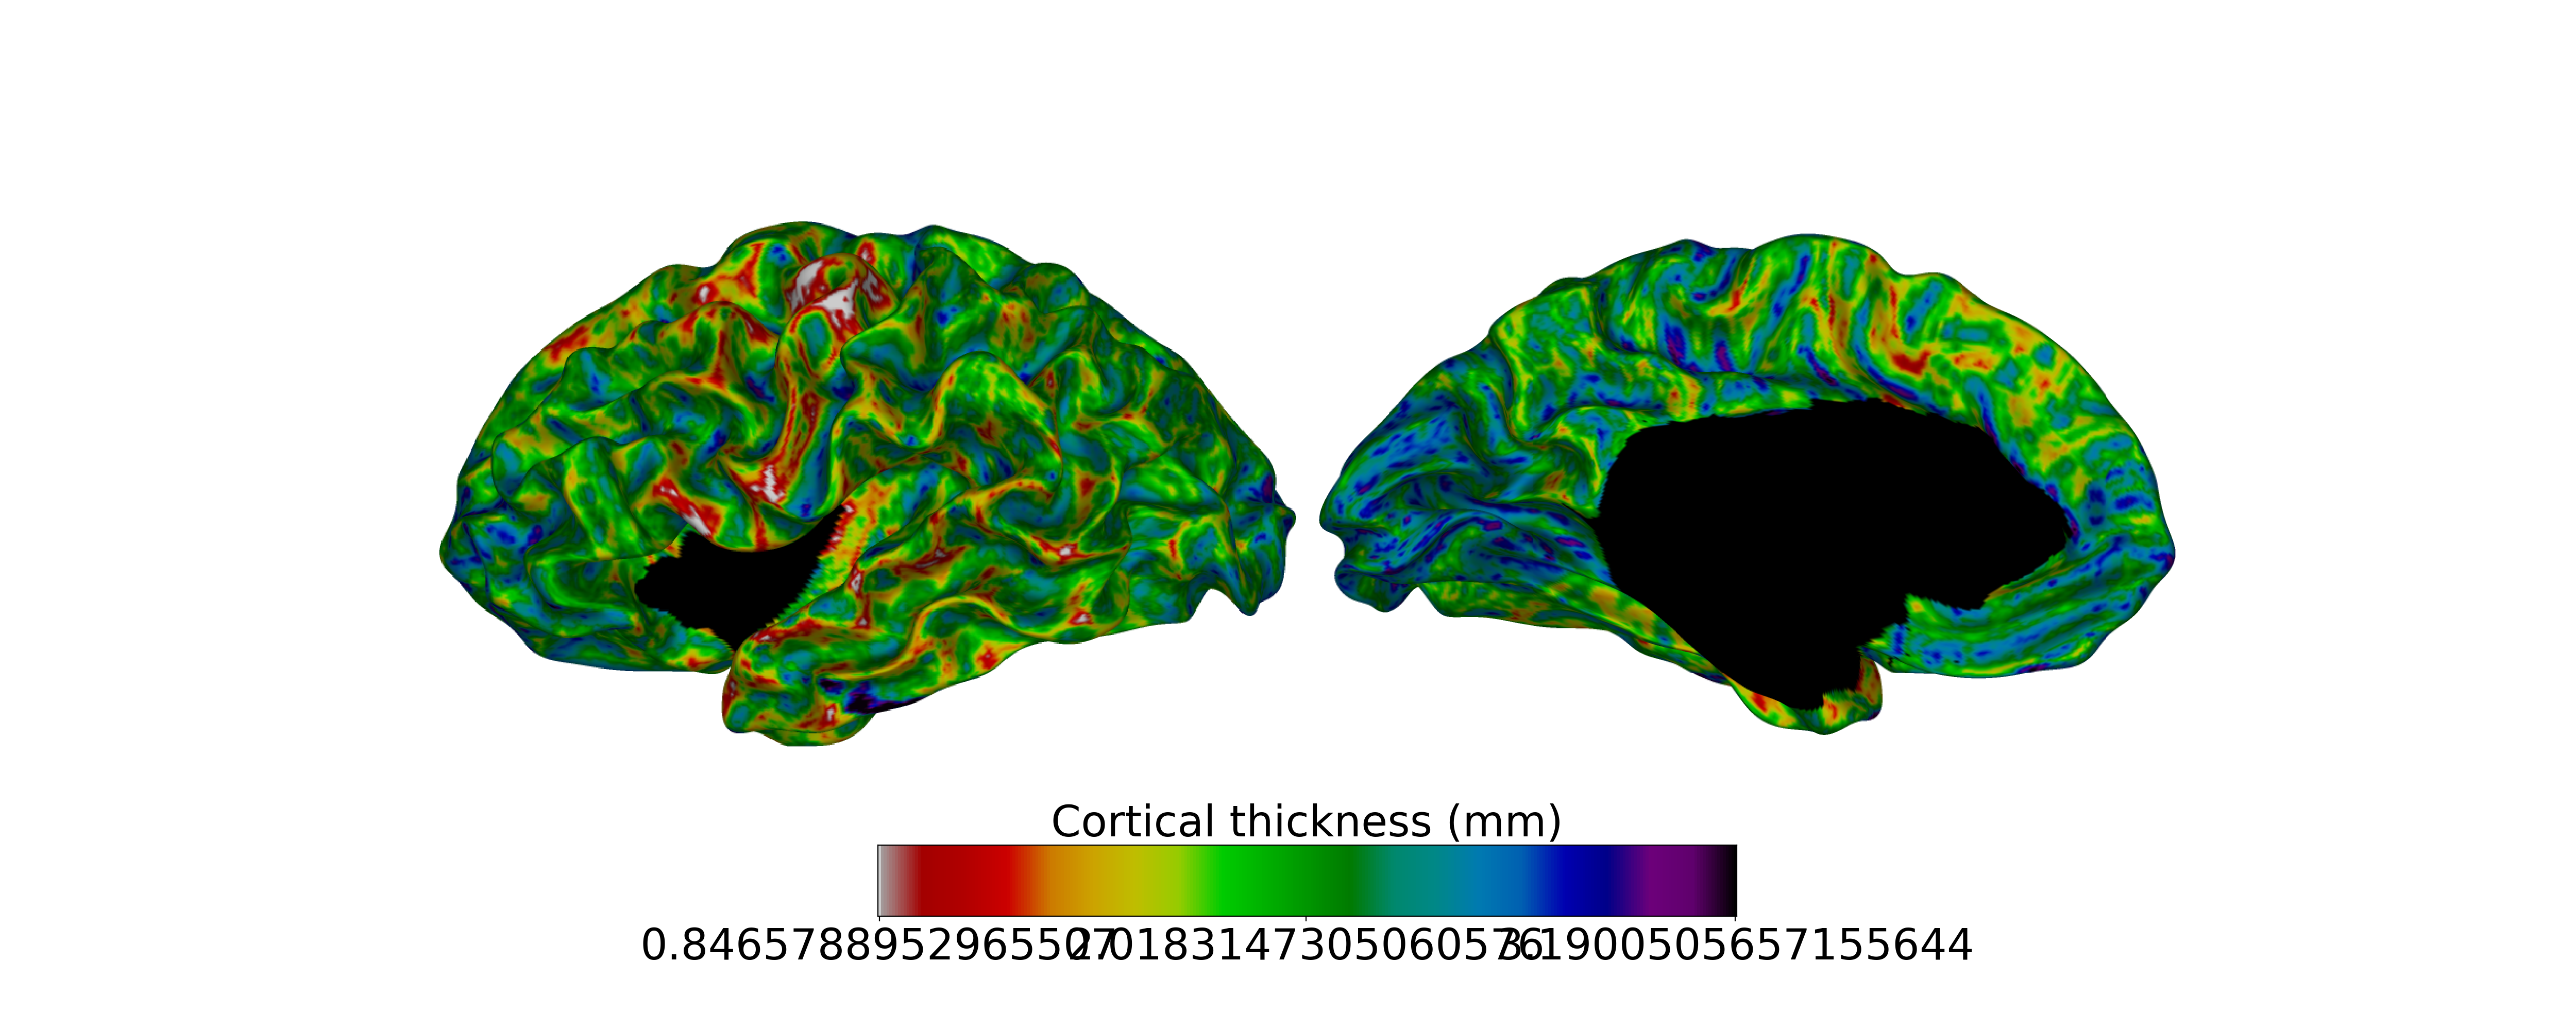

In [68]:
ncol=4
nrow=2
fig = plt.figure(figsize=(25, 10)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)

ax= plt.subplot(gs[0,0:2])
ax.imshow(l)
ax.axis('off')
ax= plt.subplot(gs[0,2:4])

ax.imshow(r)
ax.axis('off')
ax= plt.subplot(gs[1,1:3])
ax.imshow(np.rot90(bar[-:]))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,149,299])
ax.set_xticklabels([np.round(min_val,decimals=2),np.round(mu,decimals=2),np.round(max_val,decimals=2)],size=30)
ax.set_title('Cortical thickness (mm)', size=30)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness.pdf')

<IPython.core.display.Javascript object>


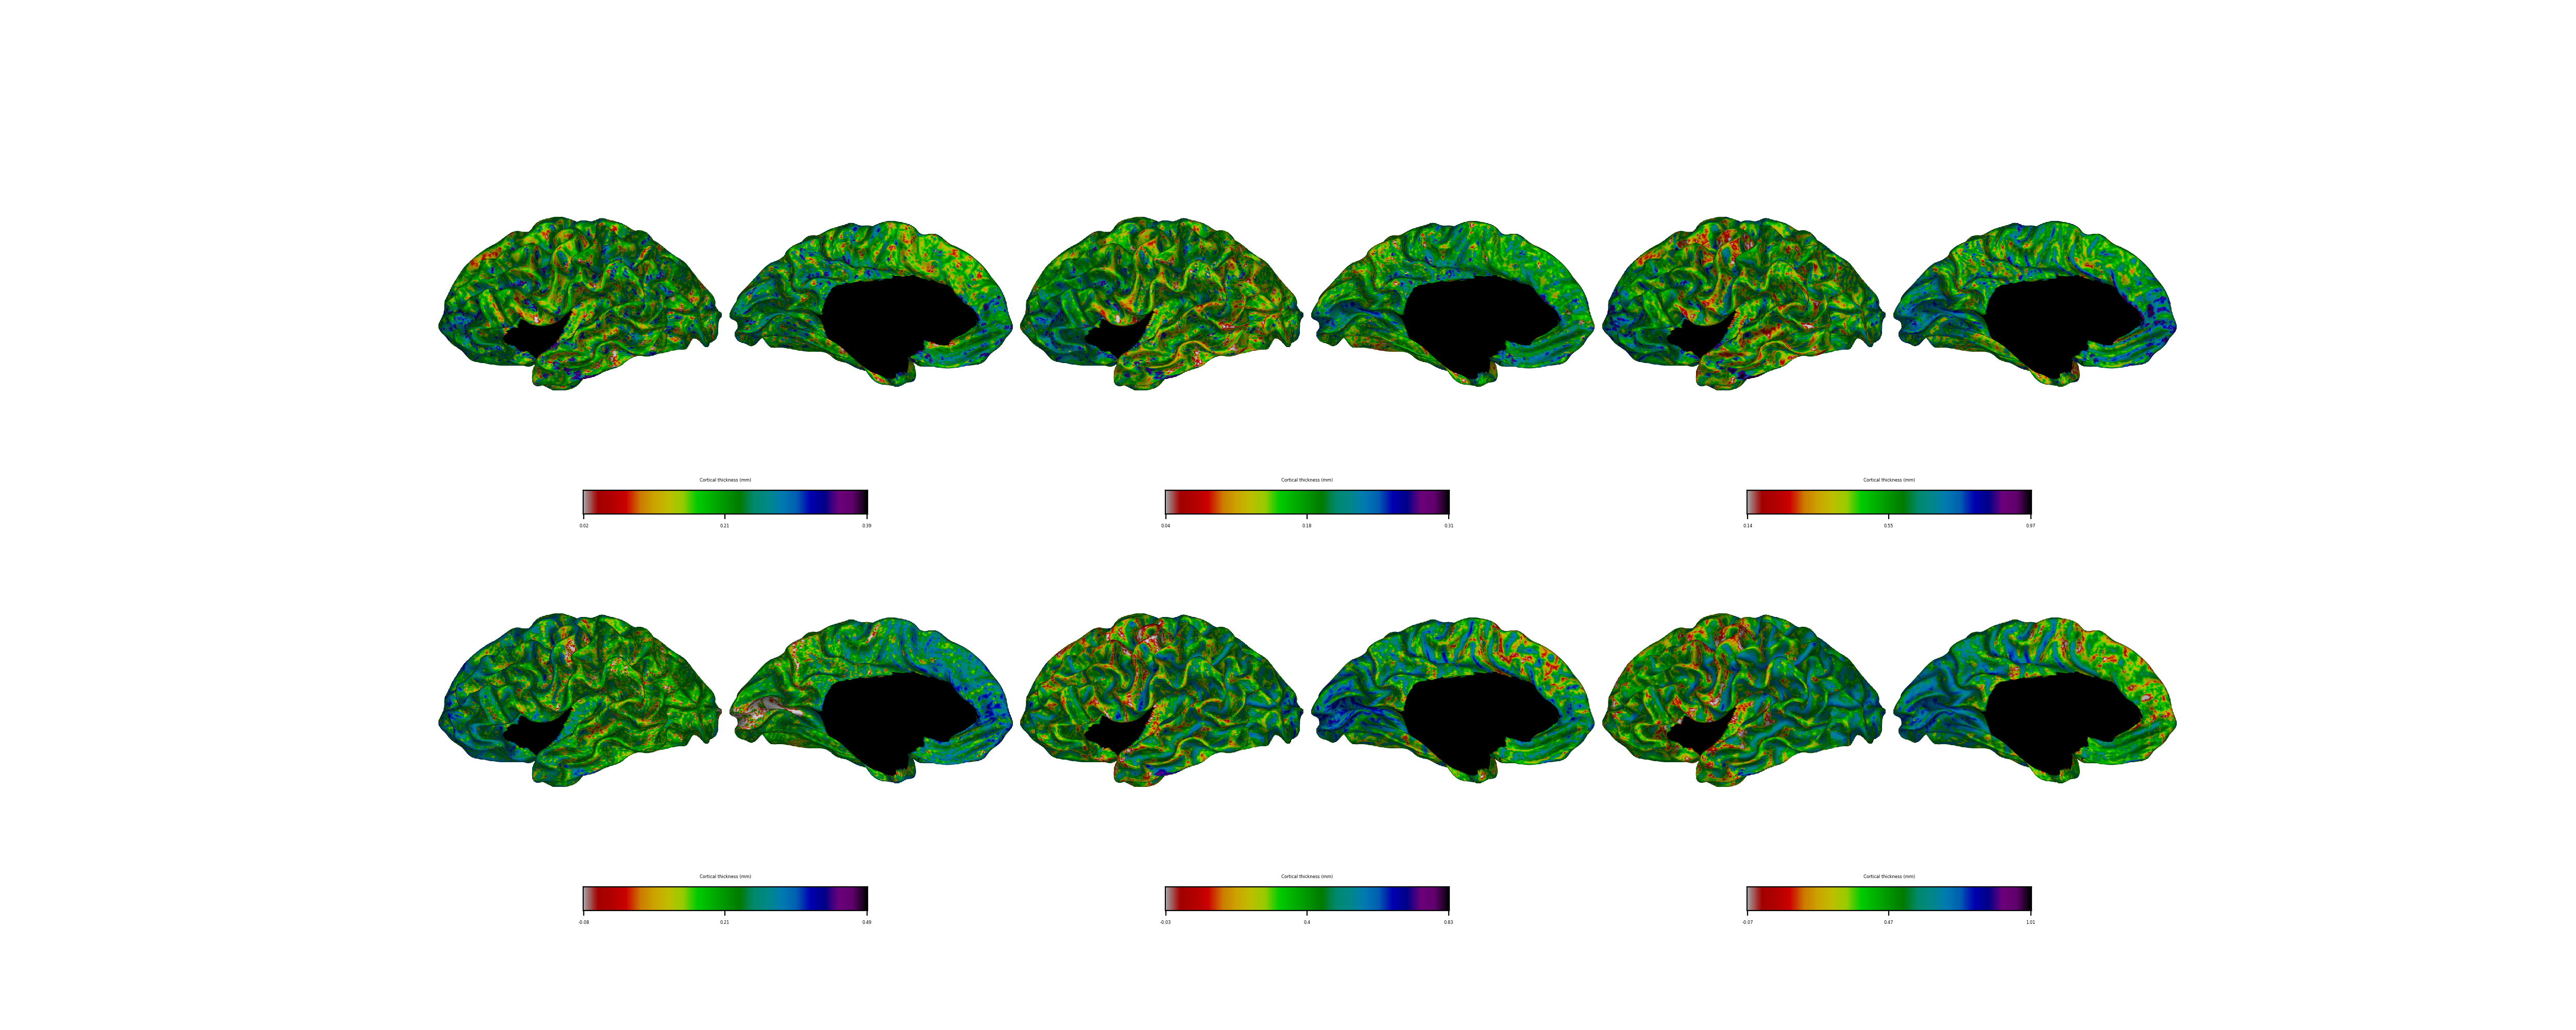

0 0
4 0
8 0
0 2
4 2
8 2


In [88]:
ncol=12
nrow=4
fig = plt.figure(figsize=(25, 10)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), height_ratios=[1,0.1,1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)



for layer in range(6):
    c=4*(layer%3)
    ro=2*(layer//3)
    print(c,ro)
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/lthickness_left_layer'+str(layer+1)+'.txt')
    mu=np.mean(overlay[mask!=1])
    sigma=np.std(overlay[mask!=1])
    min_val=mu-3*sigma
    max_val=mu+3*sigma
    l,r, bar = plot_surface(overlay, surface_file,mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[ro,c:c+2])
    ax.imshow(l)
    ax.axis('off')
    ax= plt.subplot(gs[ro,c+2:c+4])

    ax.imshow(r)
    ax.axis('off')
    ax= plt.subplot(gs[ro+1,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,149,299])
    ax.set_xticklabels([np.round(min_val,decimals=2),np.round(mu,decimals=2),np.round(max_val,decimals=2)] ,size=3)
    ax.set_title('Cortical thickness (mm)', size=3)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness.pdf')


In [29]:
overlays=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt').T
surface_file='/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/tmp_2.0_white_left_up_iso.obj'
mask=np.zeros(len(overlays.T))

0 0
4 0
8 0
12 0
0 2
4 2
8 2
12 2


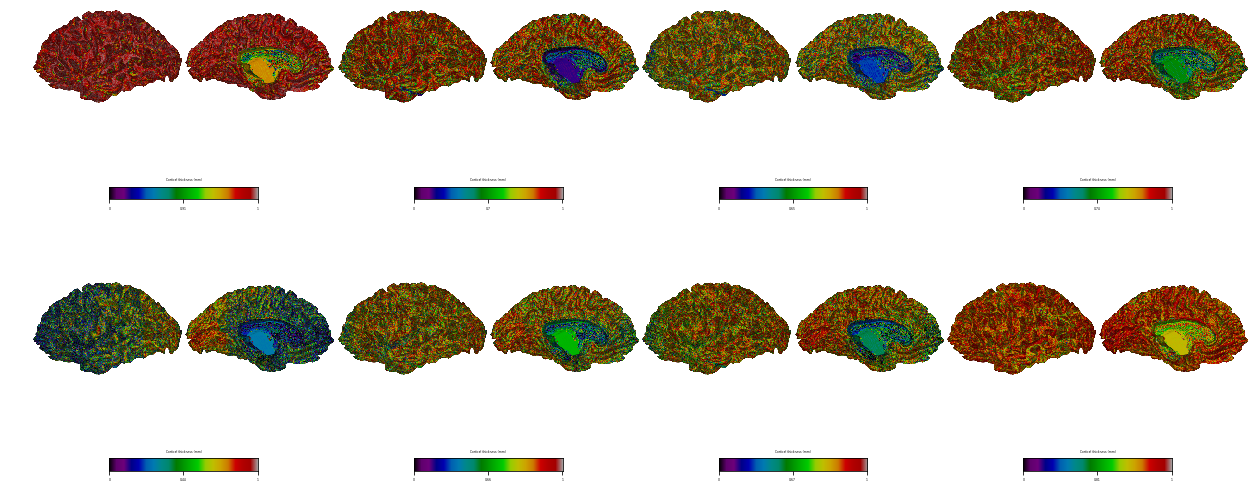

In [40]:
ncol=16
nrow=4
fig = plt.figure(figsize=(25, 10)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), height_ratios=[1,0.1,1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)

overlays=np.nan_to_num(overlays)

for layer in range(8):
    c=4*(layer%4)
    ro=2*(layer//4)
    print(c,ro)
    overlay=overlays[layer]
    mu=np.mean(overlay[mask!=1])
    sigma=np.std(overlay[mask!=1])
    min_val=0 #mu-3*sigma
    max_val=1 #mu+3*sigma
    l,r, bar = plot_surface(overlay, surface_file,mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[ro,c:c+2])
    ax.imshow(l)
    ax.axis('off')
    ax= plt.subplot(gs[ro,c+2:c+4])

    ax.imshow(r)
    ax.axis('off')
    ax= plt.subplot(gs[ro+1,c+1:c+3])
    ax.imshow(np.rot90(bar[::-1]))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,149,299])
    ax.set_xticklabels([np.round(min_val,decimals=2),np.round(mu,decimals=2),np.round(max_val,decimals=2)] ,size=3)
    ax.set_title('Cortical thickness (mm)', size=3)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/confidences.pdf')


In [31]:
l=overlays[5]

In [39]:
bar[::-1]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        ...,
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098]],

       [[0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        ...,
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196]],

       ...,

       [[0.6392157 , 0.5529412 , 0.5529412 ],
        [0.6392157 , 0.5529412 , 0.5529412 ],
        [0.6392157 , 0